# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [6]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [7]:
from tqdm import tqdm
import torch.nn.functional as F

In [9]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 12:06:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 211011981 (201M) [application/x-httpd-php]
Сохранение в: «data.txt.zip»

data.txt.zip        100%[===================>] 201,24M   290KB/s    за 8m 59s  

2021-10-26 12:15:31 (382 KB/s) - «data.txt.zip» сохранён [211011981/211011981]



In [36]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [62]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

### По совету из канала в тг, в дальнейшем отмасштабирую целевую переменную с помощью самого большого года.

In [63]:
scale_y = max(y)

In [64]:
scale_y

2011

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [14]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [15]:
regressor = Ridge()
regressor.fit(X_train, y_train)

Ridge()

In [16]:
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

9.510160711373397

In [17]:
def calculation_for_best_constant_predict():
    best_metric = 10 ** 10
    best_year = 0
    options = set(y_train)
    for option in options:
        error = mean_squared_error(y_test, np.array([[option] * len(y_test)]).transpose(), squared=False)
        if error < best_metric:
            best_metric = error
            best_year = option
    return best_metric, best_year

In [18]:
calculation_for_best_constant_predict()

(10.863228020678134, 1998)

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [19]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [22]:
X_train = scaler.transform(X_train)

In [23]:
X_test = scaler.transform(X_test)

#### Масштарбируем таргет переменную для лучшего обучения.

In [ ]:
def y_scaler(y):
    return (y - mean(y)) / 

In [65]:
y_train = y_train / scale_y
y_test = y_test / scale_y
#scaler_y = StandardScaler().fit(y.reshape(-1, 1))
#y_train = scaler_y.transform(y_train.reshape(-1, 1))
#y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [69]:
set_random_seed(12345)
train_set = np.hstack((X_train, y_train.reshape(463715, 1)))
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=16,
    shuffle=True,
) 

test_set = np.hstack((X_test, y_test.reshape(51630, 1)))
test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=51630,
    shuffle=True, 
) 

model = nn.Sequential(
    nn.Linear(90, 128), 
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(10, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=2.5 * 1e-4) 
criterion = nn.MSELoss().float()

In [70]:
train_error = []
test_error = []

In [71]:
set_random_seed(123)
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    for epoch in tqdm(range(13)):
        # тренировка
        test_loss = []
        for batch in tqdm(train_loader):
            x_train = torch.tensor([np.array(attribute[:90]) for attribute in batch])
            y_train = torch.tensor([answer[90] for answer in batch]).squeeze() 
            
            y_pred = model(x_train.float()).squeeze() 
            #y_pred = scaler_y.inverse_transform(y_pred.detach().numpy())
            #y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1).detach().numpy())
            loss = torch.sqrt(criterion(y_pred.float() * scale_y, y_train.float() * scale_y)) # обратно масштабируем целевые переменные для конкретных значений ошибки
            #loss = criterion(torch.tensor(y_pred).float(), torch.tensor(y_train).float()).requires_grad_(True)
            test_loss.append(loss.detach().numpy())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        train_error.append(np.sqrt(np.mean(test_loss)))
        
        
        # валидация
        print(f"Epoch: {epoch + 1}")
        test(model, criterion, test_loader)
    


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = torch.tensor([])
    val_loss = []
    with torch.no_grad():
        for batch_val in test_loader:
            print(len(batch_val))
            x_val = torch.tensor([np.array(attribute[:90]) for attribute in batch_val])
            y_val = torch.tensor([answer[90] for answer in batch_val]).squeeze()   
                
            y_pred = model(x_val.float()).squeeze() 
            #y_pred = scaler_y.inverse_transform(y_pred.detach().numpy())
            #y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1).detach().numpy())
            y_pred *= scale_y # делаем обратное масштабирование для корректных прогнозов и ошибок
            y_val *= scale_y
            loss = torch.sqrt(criterion(y_pred, y_val)) 
            #loss = torch.sqrt(criterion(torch.tensor(y_pred).squeeze().float(), torch.tensor(y_val).squeeze().float()))
            #loss
                
            val_loss.append(loss.detach().numpy())
            predicts = torch.cat((predicts, y_pred))
    test_error.append(np.mean(val_loss))
    print(f"loss: {np.mean(val_loss)}")
    return predicts 

In [72]:
set_random_seed(123) 
train(model, optimizer, criterion, train_loader, test_loader)

 31%|███       | 9007/28983 [00:14<00:30, 652.99it/s]


 59%|█████▊    | 16973/28983 [00:30<00:19, 621.32it/s]


 89%|████████▉ | 25910/28983 [00:44<00:05, 603.88it/s]


100%|██████████| 28983/28983 [00:49<00:00, 586.19it/s]


Epoch: 1
51630


  0%|          | 60/28983 [00:00<00:48, 594.94it/s]

loss: 9.819886455225603



 32%|███▏      | 9138/28983 [00:14<00:31, 638.84it/s]


 61%|██████    | 17655/28983 [00:29<00:26, 428.17it/s]


 92%|█████████▏| 26534/28983 [00:44<00:03, 634.95it/s]


100%|██████████| 28983/28983 [00:47<00:00, 605.15it/s]


Epoch: 2
51630


  0%|          | 58/28983 [00:00<00:50, 572.22it/s]

loss: 9.334400147842526



 32%|███▏      | 9245/28983 [00:14<00:39, 499.24it/s]


 58%|█████▊    | 16730/28983 [00:29<00:21, 569.81it/s]


 86%|████████▋ | 25024/28983 [00:43<00:06, 580.25it/s]


100%|██████████| 28983/28983 [00:50<00:00, 570.26it/s]


Epoch: 3
51630


  0%|          | 53/28983 [00:00<00:55, 523.26it/s]

loss: 9.274806914556736



 28%|██▊       | 8127/28983 [00:14<00:40, 517.29it/s]


 55%|█████▌    | 15982/28983 [00:29<00:24, 527.52it/s]


 82%|████████▏ | 23745/28983 [00:43<00:09, 553.04it/s]


100%|██████████| 28983/28983 [00:52<00:00, 547.11it/s]


Epoch: 4
51630


  0%|          | 52/28983 [00:00<00:55, 518.05it/s]

loss: 9.118386690958973



 29%|██▊       | 8285/28983 [00:14<00:38, 536.18it/s]


 55%|█████▌    | 15995/28983 [00:29<00:23, 543.73it/s]


 82%|████████▏ | 23687/28983 [00:43<00:10, 527.52it/s]


100%|██████████| 28983/28983 [00:54<00:00, 536.44it/s]


Epoch: 5
51630


  0%|          | 17/28983 [00:00<02:51, 169.30it/s]

loss: 9.194436664108814



 25%|██▌       | 7362/28983 [00:15<00:43, 500.06it/s]


 51%|█████     | 14751/28983 [00:29<00:28, 503.54it/s]


 76%|███████▋  | 22124/28983 [00:44<00:13, 503.49it/s]


100%|██████████| 28983/28983 [00:56<00:00, 513.28it/s]


Epoch: 6
51630


  0%|          | 52/28983 [00:00<00:56, 516.08it/s]

loss: 9.047808030248556



 28%|██▊       | 8197/28983 [00:14<00:37, 548.24it/s]


 56%|█████▌    | 16177/28983 [00:29<00:22, 559.56it/s]


 82%|████████▏ | 23752/28983 [00:43<00:10, 491.16it/s]


100%|██████████| 28983/28983 [00:53<00:00, 536.85it/s]


Epoch: 7
51630


  0%|          | 48/28983 [00:00<01:00, 474.82it/s]

loss: 9.502013358915928



 26%|██▌       | 7471/28983 [00:14<00:43, 492.24it/s]


 51%|█████     | 14827/28983 [00:29<00:29, 486.85it/s]


 76%|███████▋  | 22146/28983 [00:43<00:12, 530.27it/s]


100%|██████████| 28983/28983 [00:56<00:00, 512.13it/s]


Epoch: 8
51630


  0%|          | 45/28983 [00:00<01:05, 443.73it/s]

loss: 9.202461361421564



 62%|██████▏   | 8/13 [07:14<04:31, 54.35s/it]


KeyboardInterrupt: 

In [104]:
set_random_seed(123)
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

loss: 8.73432037017621


#### Обучаю модель до 13 эпохи, так как по графику ниже видно, что при дальнейших эпохах ошибка на тесте скорее всего не будет ниже достигнутого минимума.

In [92]:
import matplotlib.pyplot as plt

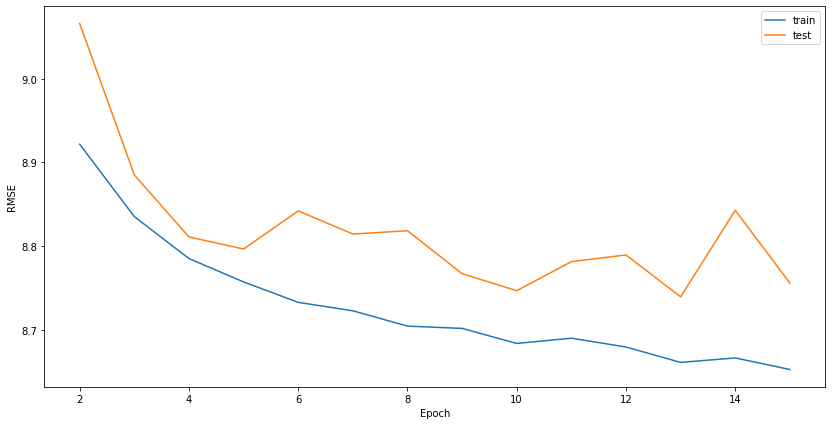

In [93]:
plt.figure(figsize=(14, 7))
plt.plot(range(2, 16), train_error[1:], label="train")
plt.plot(range(2, 16), test_error[1:], label="test")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

#### Первой попыткой была реализовация модели со следующей архитектурой: 90 -> 50 -> 10 -> 1, после каждого слоя был батчнорм и дропаут. Предобрабатывались только признаки с помощью StandardScaler из sklearn. В качестве оптимизатора брал обычный SGD. С данной архитектурой пытался подобрать гиперпараметры, но примерно ниже 10 RMSE не падал. 


#### Следующим вторым этапом, который более менее улучшил метрику, можно выделить модель почти  с такой же архитектурой, но другой предобработкой: вместо StandardScaler я использовал MinMaxScaler. В моделе различался только слой, отвечающий за дропаут, где раньше было 0.6, но в ходе экспериментов я заметил, что при меньшем дропауте выходит лучшее качество. В добавок к этому, пытался прикрутить momentum к SGD, и это тоже помогало немного улучшить качество модели. В результате, удавалось достичь RMSE в районе 9.

#### Финальной структурой стало то, что я немного изменил модель: в полносвязном слое, где раньше было 50 нейронов, я установил 128 нейронов. Но самым прорывом стало то, что я начал масштабировать целевую переменную для лучшего обучения модели. Помимо этого, вместо обычного SGD я начал использовать Adam с шагом между 10^-3 и 10^-4. В результате всех этих манипуляций, качество удалось значительно улучшить, и достигнуть RMSE ниже 8.75. 